# RespiCoV sequencing analysis by primer

Analyze fastq file(s) from nanopore sequencing output using [RespiCoV](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264855) primers. Designed for ligation sequencting chemistry.



## Initialization and configuration

In [3]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import Align
import matplotlib_inline.backend_inline
import os
import pandas as pd
import RCUtils
import random

%load_ext autoreload
%autoreload 1
%aimport RCUtils

# Get high-dpi output for retina displays
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Be deterministic
random.seed(42)

fastQBaseDir = "../RVP1/merged/fastq_pass/"

pd.options.display.max_rows = 50
pd.options.display.min_rows = 25

primers = RCUtils.readPrimers("RVPPrimers.fasta")
print("Read %i primers" % (len(primers)))

# Compute and save primer matches if needed
RCUtils.generateAllHitsFiles(primers, fastQBaseDir)

def getAllPrimerMatches():
    return RCUtils.getAllPrimerMatches(primers, fastQBaseDir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Read 22 primers
Processing  APC648_pass_barcode05_641ecf93_5ef21801_0.fastq.gz  0.01s
Processing  APC774_pass_barcode05_a5efdaf2_9ec687e4_0.fastq.gz  0.10s
Processing  APC648_pass_barcode06_641ecf93_5ef21801_0.fastq.gz  0.00s
Processing  APC774_pass_barcode06_a5efdaf2_9ec687e4_0.fastq.gz  0.03s
Processing  APC648_pass_barcode07_641ecf93_5ef21801_0.fastq.gz  0.01s
Processing  APC774_pass_barcode07_a5efdaf2_9ec687e4_0.fastq.gz.  0.12s
Processing  APC648_pass_barcode08_641ecf93_5ef21801_0.fastq.gz  0.00s
Processing  APC774_pass_barcode08_a5efdaf2_9ec687e4_0.fastq.gz  0.03s
Processing  APC774_pass_barcode09_a5efdaf2_9ec687e4_0.fastq.gz  0.01s
Processing  APC648_pass_barcode10_641ecf93_5ef21801_0.fastq.gz  0.01s
Processing  APC774_pass_barcode10_a5efdaf2_9ec687e4_0.fastq.gz  0.02s
Processing  APC648_pass_barcode11_641ecf93_5ef21801_0.fastq.gz  0.00s
Processing  APC774_pass_barcode11_a5efdaf2_9ec687e4_0.f

## How many primers are found in each read?
Notable here is that, in my first experiment nearly every read included at least one primer, suggesting PCR products did dominate the results. 
Proper amplification and sequencing should typically result in 2 primers per read, which is indeed the most common result. But it's also very common to have only a single primer.
It's also not unusual to have several primers, suggesting primer-dimers.

In [11]:
from collections import Counter

readsPerPrimerCount = Counter()
readTotal = 0
for (subdir, read, hits) in getAllPrimerMatches():
    readTotal += 1
    readsPerPrimerCount[len(hits)] += 1
print("%i total reads" % readTotal)

table = pd.DataFrame.from_dict(readsPerPrimerCount, orient="index", columns=["Reads"])
table.index.name = "Primer Count"
table.sort_index(inplace=True)
table["%"] = table["Reads"].apply(lambda r: round(r / readTotal, ndigits=4))
table

522 total reads


,Reads,%
Primer Count,,
0,114,0.2184
1,119,0.2280
2,109,0.2088
3,98,0.1877
4,55,0.1054
5,19,0.0364
6,3,0.0057
7,2,0.0038
8,1,0.0019


This is similar to my RC1 run but with about half the reads and 10pp fewer 2-primer reads.

## What is the distribution of primer match scores
Most hits exactly match a primer, but small numbers of mismatches are not uncommon.
In earlier testing, match scores of around 60% and lower were extremely common, purely by chance.

371 of 1005 (36%) of primer hits are a perfect match


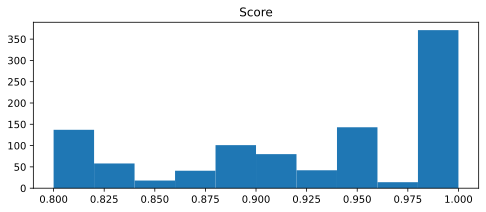

In [12]:
mrs = []
perfect = 0
for (subdir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        mrs.append(hit.mr)
        if hit.mr == 1.0:
            perfect += 1

print("%d of %d (%d%%) of primer hits are a perfect match" % (perfect, len(mrs), 100*perfect/len(mrs)))
pd.DataFrame({'Score': mrs}).hist(figsize=(8,3), bins=10, grid=False);

## How often is each primer seen?
With a highly-specific PCR reaction I would expect to see the primer matches dominated by the legitimate target sequences. That's not the case here, suggesting perhaps the annealing temp was too low. More analysis is clearly needed in order to identify likely targets in the data.

,Fwd hits,Rev hits,%,Avg MR
Primer,,,,
HRVma-r,140,88,22.69,0.95
HRVka5-ri,109,65,17.31,0.94
HRVma-f,99,74,17.21,0.93
ENTrc-r,92,54,14.53,0.86
ADVri-f,36,17,5.27,0.93
ENTrc-f1,30,19,4.88,0.92
OC43ha-f,26,15,4.08,0.91
SC2N2cdc-f,23,2,2.49,0.98
ADVri-r.0,7,17,2.39,0.94


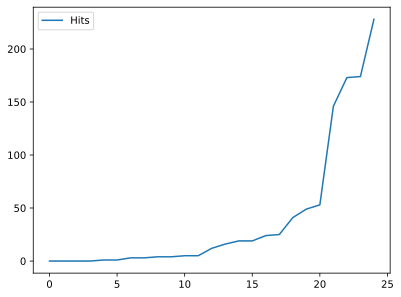

In [13]:
hitsPerPrimer = dict()
for p in primers:
    hitsPerPrimer[p.description] = [0,0,0]

hitsTotal = 0
for (subdir, record, hits) in getAllPrimerMatches():
    hitsTotal += len(hits)
    for hit in hits:
        hitsPerPrimer[hit.primer.description][1 if hit.rev else 0] += 1
        hitsPerPrimer[hit.primer.description][2] += hit.mr

def addPercent (entry):
    (primer, [fwd,rev,mrtot]) = entry
    return (primer, fwd, rev, round((fwd+rev) / hitsTotal * 100, ndigits=2), round(mrtot / (fwd+rev), ndigits=2))

allHits = sorted([f+r for (f, r, m) in hitsPerPrimer.values()])
pd.DataFrame(allHits, columns=["Hits"]).plot()

data = map(addPercent, filter(lambda p:p[1]!=[0,0,0], hitsPerPrimer.items()))
table = pd.DataFrame(data, columns=["Primer","Fwd hits", "Rev hits", "%", "Avg MR"])
table.set_index("Primer", inplace=True)
table.sort_values("%", ascending=False, inplace=True)
table

## Which primers are never seen exactly?
Given the high rate of off-target amplification in this experiment, if a primer is never seen at all, that may suggest a failure in the assay preparation
or synthesis. 

In [14]:
primerMaxMatch = dict.fromkeys(map(lambda p:p.description, primers), (0,0.0))

for (subdir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        (count, maxMr) = primerMaxMatch[hit.primer.description]
        primerMaxMatch[hit.primer.description] = (count+1, max(maxMr, hit.mr))

table = pd.DataFrame.from_dict(primerMaxMatch, orient="index", columns=["Hits", "Max Match"])
table.index.name = "Primer"
table.sort_values("Max Match", ascending=False, inplace=True)
table[table["Max Match"] < 1.0]

,Hits,Max Match
Primer,,
HRVka5-ro,12,0.96
HBoVri-f.0,3,0.95
SC2N2cdc-r,3,0.94
ADVri-r.3,1,0.91
ADVri-r.2,1,0.87
NL63ha-r,0,0.00
NL63ha-f,0,0.00
HRVka5-f,0,0.00
Random control,0,0.00


There's no hits to the random control primer.

The same weak Influenza and RSV hits from RC1 also show up here as weak or missing, further suggesting those primers could be missing from the primer pool. But there are additional missing primer hits here, so perhaps this just represents better priming.

## What's the distribution of read lengths per subdir
We should expect this to look similar to gel output minus some constant offset for the adapters/barcodes. Note that unlike the RC1 run, I kept the default min length of 200bp.

108 of 522 (20%) reads are less than 200bp


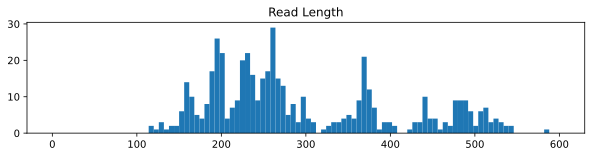

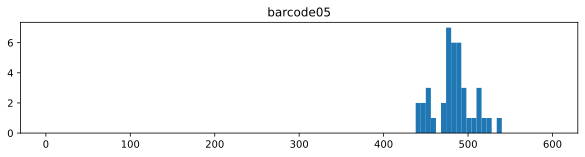

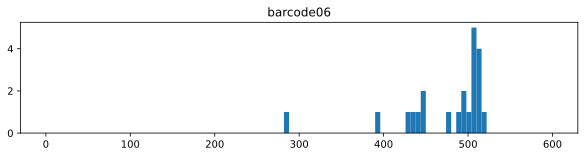

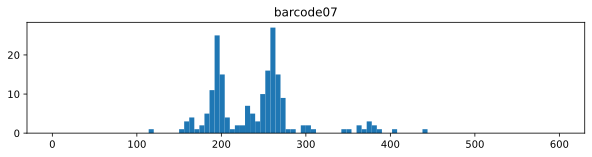

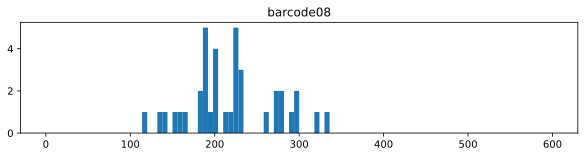

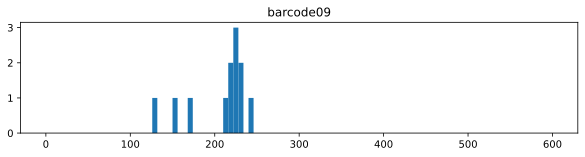

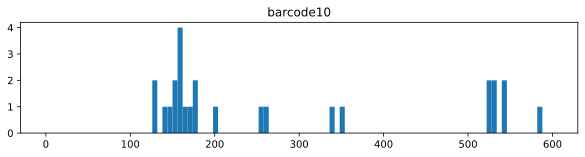

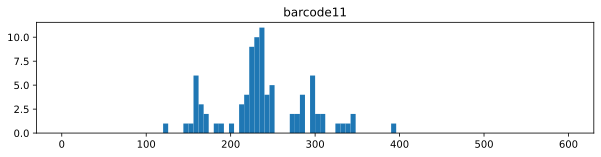

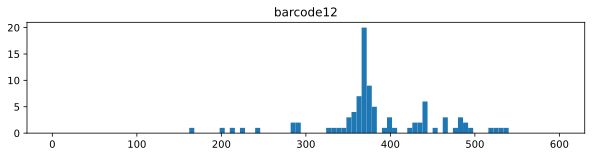

In [15]:
lessThan200 = 0
lengths=[]
for (subdir, read, hits) in getAllPrimerMatches():
    lengths.append(len(read.seq))
    if len(read.seq) < 200:
        lessThan200 += 1
pd.DataFrame({'Read Length': lengths}).hist(bins=100, figsize=(10,2), grid=False, range=(0,600));
print ("%d of %d (%d%%) reads are less than 200bp" % (lessThan200, len(lengths), 100*lessThan200/len(lengths)))

for fastQDir in RCUtils.getAllFastQDirs(fastQBaseDir):
    lengths=[]
    for (read, hits) in RCUtils.getPrimerMatches(primers, fastQDir):
        lengths.append(len(read.seq))
    subdir=os.path.basename(fastQDir)
    pd.DataFrame({subdir: lengths}).hist(bins=100, figsize=(10,2), grid=False, log=False, range=(0,600));    

Reads are relatively evenly distributed by barcode. 

## What's the distribution of primer positions?

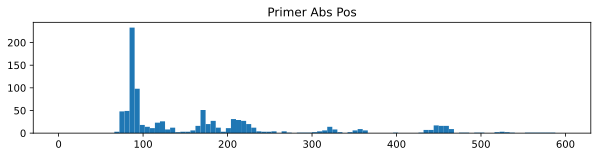

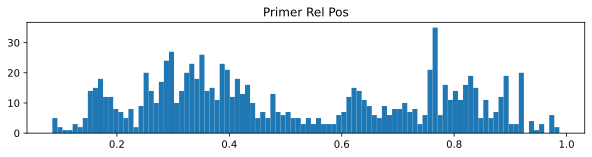

In [16]:
paPos=[]
prPos=[]

for (subdir, read, hits) in getAllPrimerMatches():
    paPos += map(lambda hit: hit.end, hits)
    prPos += map(lambda hit: (hit.start+hit.end)/2/len(read.seq), hits)

pd.DataFrame({'Primer Abs Pos': paPos}).hist(bins=100, figsize=(10,2), grid=False, range=(0,600))
pd.DataFrame({'Primer Rel Pos': prPos}).hist(bins=100, figsize=(10,2), grid=False);

The bimodal relative position may be because the most common pattern is a barcode prefix, primer, match region of arbitrary (but often low) length, primer and barcode suffix. 

## What is the distance between primer hits?
Can we tell the difference between primer-dimers and off-target amplification?

ENTrc-f1
target          835 CCGGGGAAACAGAAGTGCTTG 856
                  0 |||||||||||||||||||||  21
query             0 CCGGGGAAACAGAAGTGCTTG  21

HRVka5-ro
target           64 GAAACACGGACACCCAAAGTAGT 87
                  0 ||||||||||||||||||||||| 23
query             0 GAAACACGGACACCCAAAGTAGT 23

44% < 20bp
27% <= 0bp


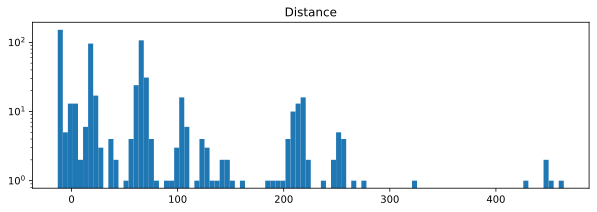

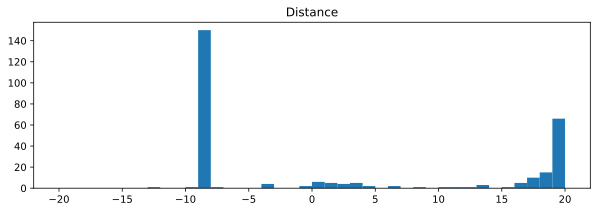

In [17]:
import matplotlib.pyplot as plt 

# Find the hits with the maximum overlap (below our threshold)
dists = []
countShort = 0
countAdjacent = 0
countTotal = 0
adjhit = None
for (subdir, read, hits) in getAllPrimerMatches():
    for i in range(len(hits)-1):
        countTotal += 1
        dist = hits[i+1].start - hits[i].end
        if dist < 20:
            countShort += 1
        if dist <= 0:
            countAdjacent += 1
        dists.append(dist)
        if dist == 0 and adjhit == None:
            adjhit = (read, hits[i], hits[i+1])

aligner = Align.PairwiseAligner(mode='local', match_score=1, mismatch_score=0, gap_score=-1)
print(adjhit[1].primer.description)
print(aligner.align(adjhit[0].seq, adjhit[1].primer.rcSeq if adjhit[1].rev else adjhit[1].primer.seq)[0])
print(adjhit[2].primer.description)
print(aligner.align(adjhit[0].seq, adjhit[2].primer.rcSeq if adjhit[2].rev else adjhit[2].primer.seq)[0])

print("%d%% < 20bp" % int(100*countShort/countTotal))
print("%d%% <= 0bp" % int(100*countAdjacent/countTotal))

df = pd.DataFrame({'Distance': dists})
df.hist(bins=100, grid=False, log=True, figsize=(10,3))
df.hist(bins=40, grid=False, range=(-20,20), figsize=(10,3));

Primer dimers are still very common in this run, but by ignoring reads shorter than 200bp we've filtered out more of them.

## How much do primer hits overlap below our threshold?
Partial overlap of primer hits is an indication of primer-dimers, which we should expect to be more common at lower overlap ratios. High or total overlapping primer hits would come from primers targetting different variants of the same locus, but we filter out such overlaps early. Look for any evidence that we haven't filtered out enough.

Max overlap score: 0.65, read 9db4effd-dafb-4d75-b421-3070382d8a3d, len 497, suffix 53
HRVma-f mr=1.00
target          293 TGGACAGGGTGTGAAGAGC 312
                  0 |||||||||||||||||||  19
query             0 TGGACAGGGTGTGAAGAGC  19

HRVka5-ri (rev) mr=0.83
target          331 TCCTCAG-CCCCTGAATG 348
                  0 |||||.|-||||||||||  18
query             0 TCCTCCGGCCCCTGAATG  18

HRVma-r (rev) mr=0.80
target          414 GGATGGGACCAACTGCTGGG 434
                  0 ||||||||||.|||.||..|  20
query             0 GGATGGGACCGACTACTTTG  20

ENTrc-r (rev) mr=0.81
target          421 ACCAACTGCTGGGTGTCCGTGTT 444
                  0 ||.|-||.-||||||||||||||  23
query             0 ACTA-CTT-TGGGTGTCCGTGTT  21



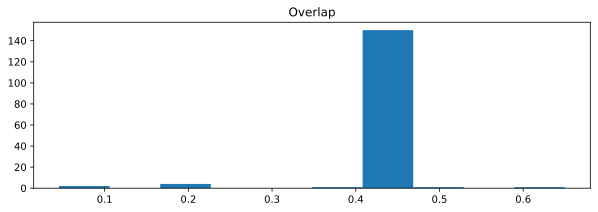

In [18]:
# Find the hits with the maximum overlap (below our threshold)
overlaps = []
maxo = 0
maxhit = None
for (subdir, read, hits) in getAllPrimerMatches():
    for i in range(len(hits)):
        for j in range(i):
            o = RCUtils.computeOverlap(hits[i],hits[j])
            if o > 0:
                overlaps.append(o)
                if o > maxo:
                    maxo = o
                    maxhit = (read, hits)

maxoend = max([h.end for h in maxhit[1]])
print("Max overlap score: %.2f, read %s, len %d, suffix %d" % 
      (maxo, maxhit[0].id, len(maxhit[0].seq), len(maxhit[0].seq) - maxoend))
for hit in sorted(maxhit[1], key=lambda h: h.start):
    print("%s%s mr=%.2f" % (hit.primer.description, " (rev)" if hit.rev else "", hit.mr))
    print(aligner.align(maxhit[0].seq, hit.primer.rcSeq if hit.rev else hit.primer.seq)[0])
      
pd.DataFrame({'Overlap': overlaps}).hist(figsize=(10,3), grid=False);

As expected, most overlap is by a small amount - just a few bases.
Looking at the read with the maximum overlap just below our 80% cutoff, it appears to be a quadruper primer-dimer combined with an off-target match. 

## What's the distribution of spans between possible primer pairs

In [2]:
spans = []
for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQBaseDir):
    spans.append(span)

df = pd.DataFrame({'Span': spans})
df.hist(bins=50, grid=False, figsize=(10,3));
df[df["Span"]>50].hist(bins=50, grid=False, figsize=(10,3));

IndexError: list index out of range

There's one obvious cluster around 350bp.

## Find the primer pairs that occur most often per subdir and analyze their spans
For any given primer pair we expect the (distance in the read from start of first primer to end of second) to be consistent from read to read in true matches, but possibly more variable for mispriming.  

In [4]:
from collections import defaultdict
import statistics

perSubdirPrimer = defaultdict(lambda:{"count":0, "spans":[], "mrs":[], "readIds":[]})
totalPairs = 0
likelyPairs = 0
goodPairs = 0

for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQBaseDir):
    totalPairs += 1
    if (span > 50):
        row = perSubdirPrimer[(subdir, pairname)]
        row["spans"].append(span)
        row["mrs"].append(hit1.mr)
        row["mrs"].append(hit2.mr)
        row["readIds"].append(read.id)

known_good_subdir_pairs = set()
known_good_reads = set()
table = {"Subdir":[], "PrimerPair":[], "Count":[], "SpanMedian":[], "SpanSD":[], "MRMedian":[]}
for ((subdir, primerpair),row) in perSubdirPrimer.items():
    count = len(row["spans"])
    if count > 1:
        likelyPairs += count
        table["Subdir"].append(subdir)
        table["PrimerPair"].append(primerpair)
        table["Count"].append(count)
        spans = row["spans"]
        table["SpanMedian"].append(round(statistics.median(spans)))
        table["SpanSD"].append(round(statistics.pstdev(spans)))
        table["MRMedian"].append(round(statistics.median(row["mrs"]), ndigits=2))
    if count > 5:
        goodPairs += count
        known_good_subdir_pairs.add((subdir, primerpair))
        known_good_reads |= set(row["readIds"])

print("Showing %d of %d possible pairs (%d%%), with %d known good" % 
      (likelyPairs, totalPairs, int(100*likelyPairs/totalPairs), goodPairs))
df = pd.DataFrame(data=table)
df.set_index(["Subdir","PrimerPair"], inplace=True)
df.sort_values("Count", ascending=False, inplace=True)
df

Showing 246 of 285 possible pairs (86%), with 234 known good


Count  SpanMedian  SpanSD  MRMedian
Subdir    PrimerPair                                      
barcode07 HRVma f/r       77         102      29      0.95
barcode05 HRVma f/r       45         103     133      0.89
          HRVka5 f/ri     35         253     103      0.94
          HRVka5 f/ro     29         347      73      0.95
barcode06 HRVma f/r       15         102       2      0.95
          HRVka5 f/ri     13         249       3      1.00
barcode11 OC43ha f/r      11          63       2      0.95
barcode06 HRVka5 f/ro      9         345       3      0.91
barcode08 ADVri f/r.1      3         116      24      0.95
          ADVri f/r.0      3         120      27      0.98
barcode09 ADVri f/r.0      2          90      39      0.91
barcode10 ADVri f/r.1      2         438      12      0.86
          ADVri f/r.0      2         446       2      1.00

Here we see true Rhinovirus hits in barcode08 (already known from prior tests) and barcode04. Expected span 353bp. 

## What are the OC43 hits?

In [6]:
def hitString(hit):
    return "%s%s [%d,%d] (%.2f)" % (hit.primer.description, " (rev)" if hit.rev else "", hit.start, hit.end, hit.mr)

match1 = None
match2 = None
for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQBaseDir, "barcode11"):
        print(">" + hitString(hit1) + " - " + hitString(hit2))
        print(read.seq[hit1.end:hit2.start])


>OC43ha f [64,85] (0.86) - OC43ha r (rev) [149,172] (0.87)
ATGTGAGGAGAAGAGCGGGAATCGGAATTATGCACCCACAAGCTAAGGAATGTCTAGAGCTACT
>OC43ha r [95,118] (1.00) - OC43ha f (rev) [180,200] (0.95)
AGTAACTGGAGCATTATAGCTGTGGGTGCATAATTCCAATCTGCGCACTCTCTCCTCATCAC
>OC43ha f [64,86] (0.86) - OC43ha r (rev) [149,172] (1.00)
AGGTGATGTGAGAGAGAGCGAGATGGAATTATGCACCCACAAGCTAAGGAATACAGAGCTACT
>OC43ha r [68,90] (0.91) - OC43ha f (rev) [155,176] (1.00)
AATAGCTCTAGACATCTATAGCTTGTGGGTGCATAATTCAATCTCTGCCTCTCTCCTCACATCAC
>OC43ha r [68,91] (0.96) - OC43ha f (rev) [157,178] (0.95)
TGCGTAGCTCTAGACATCCTTGGCTTGCGGGTGCATATTCAATCTGCCTCTCTCCCCTCACATCAC
>OC43ha r [64,87] (1.00) - OC43ha f (rev) [151,172] (0.95)
AGTAACTCTAGACATTCCTTAGCTTGTAGATATAATTCCAATCTCTGCCTCTCTCCACATCACA
>OC43ha r [71,94] (1.00) - OC43ha f (rev) [161,182] (1.00)
AGTAGCTCTAGACATTCCTTAGCTTGTGGGTGCATAATTCCAATCTCTGCCTCTCTCCTCACATCAC
>OC43ha f [73,95] (0.95) - OC43ha r (rev) [158,180] (0.87)
GTATAGAGGAGAGAGCAGAGATGGAATTATGCACCCACAAGCTAAGGAGTATCTAGAGCTACT
>OC43

## Do known good reads ever have more than 2 primer hits?

In [ ]:
from collections import defaultdict
hitCounts = defaultdict(int)
for (subdir, read, hits) in getAllPrimerMatches():
    if (read.id in known_good_reads):
        if len(hits) > 2:
            print("%s read %s (len %d)" % (subdir, read.id, len(read.seq)))
            for hit in hits:
                print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))

It's apparently quite common to have concatenated reads combining good target hits with off-target hits. It's also apparently common to have some primer-dimers attached to the primers from good reads.

## What's the cause of the high span deviation in barcode04?

In [ ]:
table = {"Read":[], "Len":[], "Span":[]}
for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQBaseDir, "barcode04"):
    if (pairname=="Rhinovirus/Enterovirus 1/3"):
        table["Read"].append(read.id)
        table["Len"].append(len(read))
        table["Span"].append(span)

df = pd.DataFrame(data=table)
df.set_index("Read", inplace=True)
df.sort_values("Span", inplace=True)
df

It looks like one read is a real outlier and others are shorter. Let's visualize this with an alignment

In [ ]:
def hitString(hit):
    return "%s%s [%d,%d] (%.2f)" % (hit.primer.description, " (rev)" if hit.rev else "", hit.start, hit.end, hit.mr)

match1 = None
match2 = None
for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQBaseDir, "barcode04"):
    if read.id=="5efec6dd-d30f-409b-a6d3-6fbec0ab345d":
        print(">" + hitString(hit1) + " - " + hitString(hit2))
        match1 = read[hit1.end:hit2.start]
    if read.id=="3bb733b2-8ea6-4dd4-a7e2-ba87df3b3c1e":
        longReadToStudy = read
        print(">" + hitString(hit1) + " - " + hitString(hit2))
        match2 = read[hit1.end:hit2.start]
print(aligner.align(match1.seq, match2.seq, "-")[0])

The long read matches well at the end, but what's the extra stuff at the start?

In [ ]:
print(match2.seq)


Ah, doing a blast search I see the same sequence is duplicated, so we have a concatemer of two hits. `computePrimerHits` returns at most one hit per primer with a TODO to find others.  Are there are other primer matches in this read?

In [ ]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq, MutableSeq

ms = MutableSeq(longReadToStudy.seq)
hits = []
while True:
    newHits = RCUtils.computePrimerHits(SeqRecord(ms), primers, True)
    if len(newHits) == 0:
        break
    for hit in newHits:
        ms[hit.start:hit.end]="N" * (hit.end-hit.start)
    hits += newHits

for hit in hits:
    print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))


Interesting, there's no matching reverse primer for the first half.

# Summary
From everything we've computed above, generate summary stats for each subdir.

In [ ]:
statsPerSubdir = defaultdict(lambda: defaultdict(int))
for (subdir, read, hits) in getAllPrimerMatches():
    stats = statsPerSubdir[subdir]
    stats["reads"] += 1
    stats["bases"] += len(read.seq)
    if len(hits) > 0:
        stats["withHits"] += 1

        # Calculate total bases covered by all hits
        hitBases = 0
        for hit in hits:
            hitBases += hit.end - hit.start

        if len(hits) > 1:
            stats["withMultipleHits"] += 1
            # Compute max distance between end of one hit and start of next
            maxSpan = 0
            for i in range(len(hits)-1):
                span = hits[i+1].start - hits[i].end
                if span < 0:
                    hitBases += span # Subtract overlap to avoid double-counting
                else:
                    stats["spanBases"] += span
                maxSpan = max(maxSpan, span)
            if maxSpan > 0:
                stats["withSpan"] += 1
                if maxSpan > 50:
                    stats["withSpanOver50"] += 1
        stats["hitBases"] += hitBases

    stats["knownGood"] += 1 if read.id in known_good_reads else 0

relStatsPerSubdir = defaultdict(dict)
for (subdir, stats) in statsPerSubdir.items():
    rs = relStatsPerSubdir[subdir]
    rs["reads"] = stats["reads"]
    rs["no hits"] = (stats["reads"] - stats["withHits"]) / stats["reads"]
    rs["lone hit"] = (stats["withHits"] - stats["withMultipleHits"]) / stats["reads"]
    rs["only dimers"] = (stats["withMultipleHits"] - stats["withSpan"]) / stats["reads"]
    rs["short span"] = (stats["withSpan"] - stats["withSpanOver50"]) / stats["reads"]
    rs["off target"] = (stats["withSpanOver50"] - stats["knownGood"]) / stats["reads"]
    rs["good"] = stats["knownGood"] / stats["reads"]
    rs["primer bases"] = stats["hitBases"] / stats["bases"]
    rs["span bases"] = stats["spanBases"] / stats["bases"]

with pd.option_context('float_format', '{:.1%}'.format):
    display(pd.DataFrame.from_dict(relStatsPerSubdir, orient='index'))